In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
import os
import glob
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import datasets, linear_model, metrics

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', None)

np.random.seed(0)

In [2]:
# converts dataframe into numpy array of correct shape
def convert(df: pd.DataFrame, frame_size=10):
    x = np.asarray(df.iloc[:, 1]).reshape(-1, frame_size)
    return x

In [3]:
######################## IMPLEMENTS PERSISTENT MINIMUM SCHEME ####

def avg(lst):
    return sum(lst) / len(lst)

def getPersistentMinimum(inp, num=5, epsilon=0.5):
    window = [inp[0]]
    for i in range(1, len(inp)):
        if abs(inp[i] - avg(window)) > epsilon: #if this prediction deviates from the running mean by more than epsilon...
            window = [inp[i]]    #start over, reset our window size
        else:
            window.append(inp[i])
        if len(window) == int(num):
            return avg(window)
    return 0

######################## IMPLEMENTS SILENT PERIODS SCHEME ####

def getForSilentPeriods(inp, rms, threshold=15):
    silentPreds = []
    for i in range(0, len(inp)):
        if rms[i] < threshold:   # if it was silent during this prediction
            silentPreds.append(inp[i])   # then add this to the list
    if len(silentPreds) > 0:
        return avg(silentPreds)
    else:
        return 0

In [4]:
######################## Load Model from .joblib file ####
from joblib import dump,load
reg = load('flowSenseRegressor.joblib')

/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DummyRegressor from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator GradientBoostingRegressor from version 0.24.2 when using version 1.0.1. This might 

Mean Squared Error:  3.0307001032856427


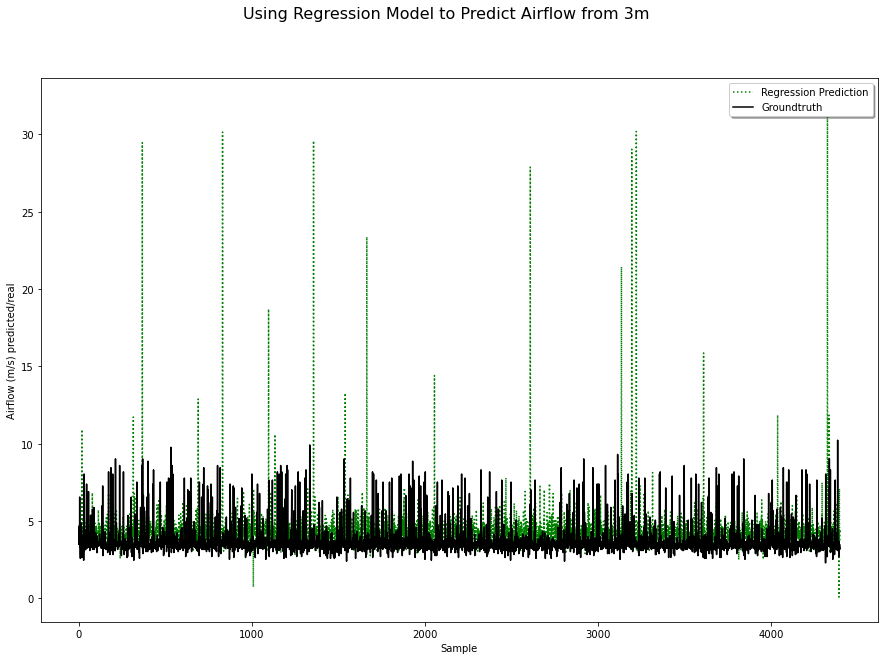

Mean Squared Error:  2.690109872995158
Mean Squared Error:  3.8255880581752217
Mean Squared Error:  1.671304189221515
Mean Squared Error:  1.4893702305365546
Mean Squared Error:  2.3288894844977013
[2.690109872995158, 3.8255880581752217, 1.671304189221515, 1.4893702305365546, 2.3288894844977013]


In [6]:
############# Looking at Naive predictions from Real World Data, 3m

MSE_scores30 = []

# Load datasets for 3m
data_dir = Path("../../Datasets/Smartphone/3m")
df1 = pd.read_csv(data_dir / "VentOne_90degrees_3meters.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1[df1['frequency'] != "silence"]
df1 = df1.dropna()

df2 = pd.read_csv(data_dir / "VentOne_180degrees_3meters.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df2 = df2[df2['frequency'] != "clocktime"]
df2 = df2[df2['frequency'] != "silence"]
df2 = df2.dropna()

df3 = pd.read_csv(data_dir / "VentOne_0degrees_3meters.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df3 = df3[df3['frequency'] != "clocktime"]
df3 = df3[df3['frequency'] != "silence"]
df3 = df3.dropna()

df = pd.concat([df1, df2, df3])
df = convert(df)

indices = np.random.choice(np.arange(df.shape[0]), size=4400, replace=False, p=None)
    
X = df[:,:-1]
X = X[indices, :6]
X.shape

y = df[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Regression Model to Predict Airflow from 3m', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-')
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

for indices in [range(4000), range(4000,8000), range(8000,12000), range(12000, 16000), range(16000, 20000)]:
    X = df[:,:-1]
    X = X[indices, :6]
    X.shape

    y = df[indices, -1]
    y.shape

    print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))
    MSE_scores30.append(mean_squared_error(reg.predict(X), y))
    
print(MSE_scores30)

Mean Squared Error:  2.8990639743644375


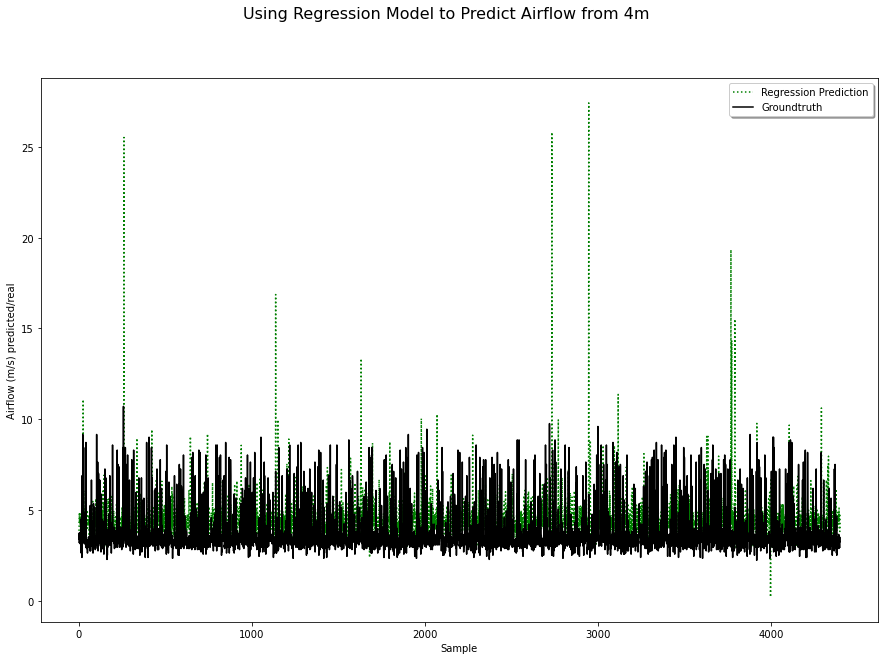

Mean Squared Error:  2.322103474292673
Mean Squared Error:  2.2918642215776175
Mean Squared Error:  2.4921456682548233
Mean Squared Error:  2.037871656372901
Mean Squared Error:  1.989896193456799
[2.322103474292673, 2.2918642215776175, 2.4921456682548233, 2.037871656372901, 1.989896193456799]


In [8]:
############# Looking at Naive predictions from Real World Data, 3m

MSE_scores40 = []

# Load datasets for 4m
data_dir = Path("../../Datasets/Smartphone/4m")
df1 = pd.read_csv(data_dir / "VentOne_90degrees_4meters.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1[df1['frequency'] != "silence"]
df1 = df1.dropna()

df2 = pd.read_csv(data_dir / "VentOne_180degrees_4meters.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df2 = df2[df2['frequency'] != "clocktime"]
df2 = df2[df2['frequency'] != "silence"]
df2 = df2.dropna()

df3 = pd.read_csv(data_dir / "VentOne_0degrees_4meters.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df3 = df3[df3['frequency'] != "clocktime"]
df3 = df3[df3['frequency'] != "silence"]
df3 = df3.dropna()

df = pd.concat([df1, df2, df3])
df = convert(df)

indices = np.random.choice(np.arange(df.shape[0]), size=4400, replace=False, p=None)
    
X = df[:,:-1]
X = X[indices, :6]
X.shape

y = df[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Regression Model to Predict Airflow from 4m', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-')
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

for indices in [range(2500), range(2500,5000), range(5000,7500), range(7500, 10000), range(10000, 12500)]:
    X = df[:,:-1]
    X = X[indices, :6]
    X.shape

    y = df[indices, -1]
    y.shape

    print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))
    MSE_scores40.append(mean_squared_error(reg.predict(X), y))
    
print(MSE_scores40)

In [9]:
from pathlib import Path

scores_P1_5u = []
scores_P1_5o = []
scores_P1_2u = []
scores_P1_2o = []
scores_P1_2h = []

################# LOOKING AT ACCURACY ON REAL WORLD DATA (with and without ambient noise) FROM PHONE 1 ####

data_dir = Path("../../Datasets/Smartphone/RealWorld")
df1 = pd.read_csv(data_dir / "PhoneOne_50cm_unoccupied.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1[df1['frequency'] != "silence"]
df1 = df1.dropna()

df2 = pd.read_csv(data_dir / "PhoneOne_50cm_OCCUPIED.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df2 = df2[df2['frequency'] != "clocktime"]
df2 = df2[df2['frequency'] != "silence"]
df2 = df2.dropna()

df3 = pd.read_csv(data_dir / "PhoneOne_2-25m_unoccupied.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df3 = df3[df3['frequency'] != "clocktime"]
df3 = df3[df3['frequency'] != "silence"]
df3 = df3.dropna()

df4 = pd.read_csv(data_dir / "PhoneOne_2-25m_OCCUPIED.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df4 = df4[df4['frequency'] != "clocktime"]
df4 = df4[df4['frequency'] != "silence"]
df4 = df4.dropna()

df5 = pd.read_csv(data_dir / "PhoneOne_InHand_OCCUPIED.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df5 = df5[df5['frequency'] != "clocktime"]
df5 = df5[df5['frequency'] != "silence"]
df5 = df5.dropna()

df = convert(df1)
for indices in  [range(3000,4000), range(4000,5000), range(5000,6000), range(6000,7000)]:
    X = df[:,:-1]
    X = X[indices, :6]
    y = df[indices, -1]
    scores_P1_5u.append(mean_squared_error(reg.predict(X), y))
        
df = convert(df2)
for indices in [range(3000,4000), range(4000,5000), range(5000,6000), range(6000,7000)]:
    X = df[:,:-1]
    X = X[indices, :6]
    y = df[indices, -1]
    scores_P1_5o.append(mean_squared_error(reg.predict(X), y))
    
df = convert(df3)
for indices in [range(1000), range(1000,2000), range(2000,3000), range(3000,4000)]:
    X = df[:,:-1]
    X = X[indices, :6]
    y = df[indices, -1]
    scores_P1_2u.append(mean_squared_error(reg.predict(X), y))
    
df = convert(df4)
for indices in [range(1000), range(1000,2000), range(2000,3000), range(3000,4000)]:
    X = df[:,:-1]
    X = X[indices, :6]
    y = df[indices, -1]
    scores_P1_2o.append(mean_squared_error(reg.predict(X), y))
    
df = convert(df5)
for indices in [range(1000), range(1000,2000), range(2000,3000), range(3000,4000)]:
    X = df[:,:-1]
    X = X[indices, :6]
    y = df[indices, -1]
    scores_P1_2h.append(mean_squared_error(reg.predict(X), y))

print("Phone1 0.5m, UNOCCUPIED SPACE")
print(sum(scores_P1_5u) / len(scores_P1_5u))
print("")
print("Phone1 0.5m, OCCUPIED SPACE")
print(sum(scores_P1_5o) / len(scores_P1_5o))
print("")
print("Phone1 2.25m, UNOCCUPIED SPACE")
print(sum(scores_P1_2u) / len(scores_P1_2u))
print("")
print("Phone1 2.25m, OCCUPIED SPACE")
print(sum(scores_P1_2o) / len(scores_P1_2o))
print("")
print("Phone1 2.25m, IN HAND")
print(sum(scores_P1_2h) / len(scores_P1_2h))

Phone1 0.5m, UNOCCUPIED SPACE
3.0209845937273934

Phone1 0.5m, OCCUPIED SPACE
3.8409857216484875

Phone1 2.25m, UNOCCUPIED SPACE
3.550428700205287

Phone1 2.25m, OCCUPIED SPACE
16.29156714613502

Phone1 2.25m, IN HAND
10.599014916132269


Mean Squared Error:  3.6950048005392446


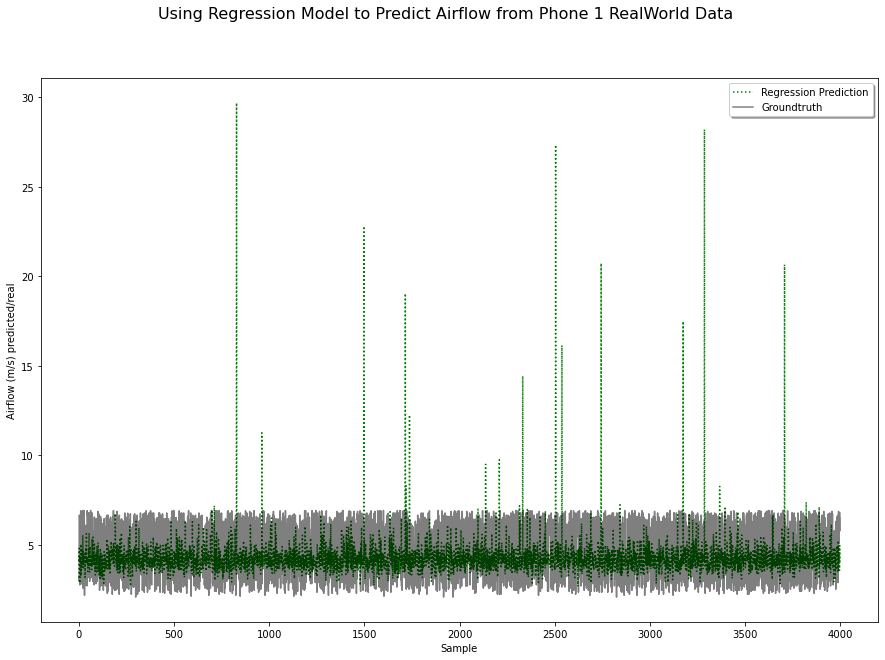

In [12]:
################# LOOKING AT PREDICTIONS ON REAL WORLD DATA (with and without ambient noise) FROM PHONE ONE ####

data_dir = Path("../../Datasets/Smartphone/RealWorld")
df1 = pd.read_csv(data_dir / "PhoneOne_50cm_unoccupied.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1[df1['frequency'] != "silence"]
df1 = df1.dropna()

df2 = pd.read_csv(data_dir / "PhoneOne_50cm_OCCUPIED.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df2 = df2[df2['frequency'] != "clocktime"]
df2 = df2[df2['frequency'] != "silence"]
df2 = df2.dropna()

df3 = pd.read_csv(data_dir / "PhoneOne_2-25m_unoccupied.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df3 = df3[df3['frequency'] != "clocktime"]
df3 = df3[df3['frequency'] != "silence"]
df3 = df3.dropna()

df4 = pd.read_csv(data_dir / "PhoneOne_2-25m_OCCUPIED.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df4 = df4[df4['frequency'] != "clocktime"]
df4 = df4[df4['frequency'] != "silence"]
df4 = df4.dropna()

df5 = pd.read_csv(data_dir / "PhoneOne_InHand_OCCUPIED.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df5 = df5[df5['frequency'] != "clocktime"]
df5 = df5[df5['frequency'] != "silence"]
df5 = df5.dropna()

# assign desired dataset to df.
# default behavior tests on 50cm unoccupied dataset.
df = df1
data_mid = convert(df)

indices = np.random.choice(np.arange(data_mid.shape[0]), size=4000, replace=False, p=None)

X = data_mid[indices,:-1]
X = X[:, :6]
X.shape

y = data_mid[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Regression Model to Predict Airflow from Phone 1 RealWorld Data', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-', alpha=0.5)
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

Mean Squared Error:  2.7584647996489418


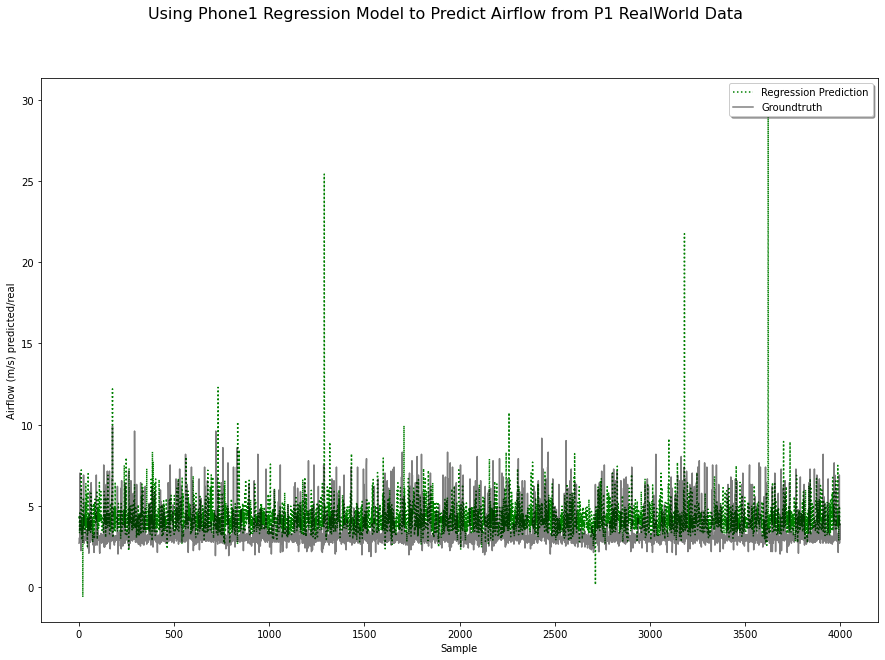

In [15]:
################# LOOKING AT PREDICTIONS ON REAL WORLD DATA (with and without ambient noise) FROM OTHER PHONES ####

data_dir = Path("../../Datasets/Smartphone/RealWorld")
df1 = pd.read_csv(data_dir / "PhoneTwo_2-25m_unoccupied.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1[df1['frequency'] != "silence"]
df1 = df1.dropna()

df2 = pd.read_csv(data_dir / "PhoneThree_2-25m_unoccupied.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df2 = df2[df2['frequency'] != "clocktime"]
df2 = df2[df2['frequency'] != "silence"]
df2 = df2.dropna()

df3 = pd.read_csv(data_dir / "PhoneFour_2-25m_unoccupied.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df3 = df3[df3['frequency'] != "clocktime"]
df3 = df3[df3['frequency'] != "silence"]
df3 = df3.dropna()

df4 = pd.read_csv(data_dir / "PhoneFour_2-25m_airflow.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df4 = df4[df4['frequency'] != "clocktime"]
df4 = df4[df4['frequency'] != "silence"]
df4 = df4.dropna()

# assign desired dataset to df.
# default behavior tests on phone two dataset.
df = df1
data_mid = convert(df)

indices = np.random.choice(np.arange(data_mid.shape[0]), size=4000, replace=False, p=None)

X = data_mid[indices,:-1]
X = X[:, :6]
X.shape

y = data_mid[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Phone1 Regression Model to Predict Airflow from P1 RealWorld Data', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-', alpha=0.5)
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()